In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [8]:
def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    
    # ROC curve
    plt.subplot(1, 2, 2)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function with your model and test generator


In [10]:
train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 13307 images belonging to 26 classes.
Found 1684 images belonging to 26 classes.
{0: 1.0640492563569486, 1: 1.0662660256410257, 2: 1.0662660256410257, 3: 1.0402595372107568, 4: 1.2273565762774397, 5: 1.0381494772975504, 6: 1.053102247546692, 7: 1.2795192307692307, 8: 1.0487862547288778, 9: 1.053102247546692, 10: 0.6486789509603198, 11: 1.0662660256410257, 12: 1.4623076923076923, 13: 0.8809082483781279, 14: 0.7571119708693673, 15: 1.0466414975617429, 16: 1.7527660695468914, 17: 0.5415954415954416, 18: 1.0662660256410257, 19: 0.9042538733351454, 20: 0.789826685660019, 21: 1.5462468045549616, 22: 1.0256667180514876, 23: 1.8085077466702908, 24: 1.0445054945054946, 25: 0.7259683578832515}


In [11]:
!pip install keras_cv_attention_models 

  Obtaining dependency information for keras_cv_attention_models from https://files.pythonhosted.org/packages/67/b4/a581ae34f6a37b021e32d1d874b8b7df4664cbb8a71659886193caf341e0/keras_cv_attention_models-1.3.22-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.8/183.8 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.2/773.2 kB 9.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstallin

In [13]:
from keras_cv_attention_models import coatnet
mm = coatnet.CoAtNet0(input_shape=(112, 112, 3), pretrained="imagenet")

93670048/93670048 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/coatnet0_160_imagenet.h5
>>>> Reload mismatched weights: 160 -> (112, 112)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb


In [14]:
from keras_cv_attention_models import swin_transformer_v2

mm2 = swin_transformer_v2.SwinTransformerV2Tiny_window8(input_shape=(112, 112, 3))


114320936/114320936 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_tiny_window8_256_imagenet.h5


In [15]:
mm_last_layer = mm.get_layer('avg_pool').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(mm.input, mm_last_layer)

In [16]:
mm2_last_layer = mm2.get_layer('avg_pool').output
#out2 = Dense(256, activation='relu', name='dense_1')(mm2_last_layer)
#out2 = Dense(11, activation='softmax', name='prediction1')(out2)
mm2_custom = Model(mm2.input, mm2_last_layer)

In [17]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([ mm_custom(inputs),mm2_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 768)                  2248765   ['input_3[0][0]']             
                                                          8                                       
                                                                                                  
 model_1 (Functional)        (None, 768)                  2757815   ['input_3[0][0]']             
                                                          4                                       
                                                                                            

In [18]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs),mm2_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 768)                  2248765   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 model_1 (Functional)        (None, 768)                  2757815   ['input_4[0][0]']             
                                                          4                                       
                                                                                            

In [19]:
num_classes = 26
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average_1').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 768)                  2248765   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 model_1 (Functional)        (None, 768)                  2757815   ['input_4[0][0]']             
                                                          4                                       
                                                                                            

In [20]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [22]:
epochs = 30

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_42/2027776823.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/30
832/831 [==============================] - ETA: 0s - loss: 1.5154 - accuracy: 0.5733 - categorical_accuracy: 0.5733 - auc: 0.9343 - precision: 0.7227 - recall: 0.4911 - true_positives: 6535.0000 - true_negatives: 330167.0000 - false_positives: 2508.0000 - false_negatives: 6772.0000 - cohen_kappa: 0.5556 - f1_score: 0.5698
Epoch 1: val_accuracy improved from -inf to 0.70071, saving model to Best_DenseNet201_v23.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


831/831 [==============================] - 467s 447ms/step - loss: 1.5154 - accuracy: 0.5733 - categorical_accuracy: 0.5733 - auc: 0.9343 - precision: 0.7227 - recall: 0.4911 - true_positives: 6535.0000 - true_negatives: 330167.0000 - false_positives: 2508.0000 - false_negatives: 6772.0000 - cohen_kappa: 0.5556 - f1_score: 0.5698 - val_loss: 0.9925 - val_accuracy: 0.7007 - val_categorical_accuracy: 0.7007 - val_auc: 0.9694 - val_precision: 0.7753 - val_recall: 0.6372 - val_true_positives: 1073.0000 - val_true_negatives: 41789.0000 - val_false_positives: 311.0000 - val_false_negatives: 611.0000 - val_cohen_kappa: 0.6881 - val_f1_score: 0.6803 - lr: 0.0010
Epoch 2/30
832/831 [==============================] - ETA: 0s - loss: 0.7870 - accuracy: 0.7571 - categorical_accuracy: 0.7571 - auc: 0.9770 - precision: 0.8060 - recall: 0.7232 - true_positives: 9624.0000 - true_negatives: 330358.0000 - false_positives: 2317.0000 - false_negatives: 3683.0000 - cohen_kappa: 0.7468 - f1_score: 0.7569
Ep

106/106 [==============================] - 22s 168ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       0.97      1.00      0.98        60
           2       0.64      0.72      0.68        60
           3       1.00      0.97      0.98        62
           4       1.00      1.00      1.00        53
           5       0.97      1.00      0.98        63
           6       0.97      1.00      0.98        62
           7       0.61      0.50      0.55        50
           8       1.00      1.00      1.00        62
           9       1.00      1.00      1.00        62
          10       1.00      1.00      1.00       100
          11       0.98      1.00      0.99        60
          12       1.00      1.00      1.00        45
          13       1.00      1.00      1.00        74
          14       1.00      0.98      0.99        86
          15       0.98      1.00      0.99        62
          16       1.00

/tmp/ipykernel_42/2485669865.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


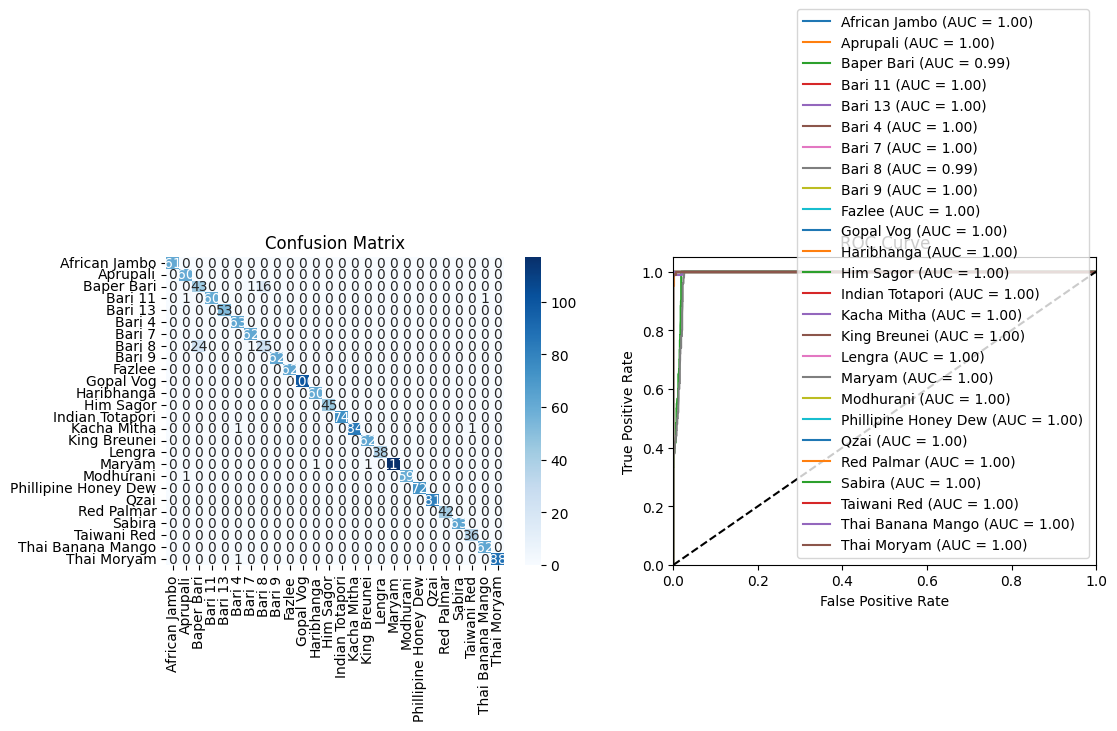

In [23]:
evaluate_(final_model, generator_test)

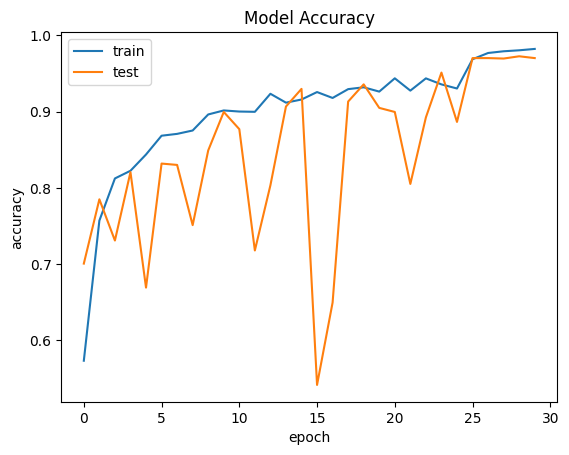

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

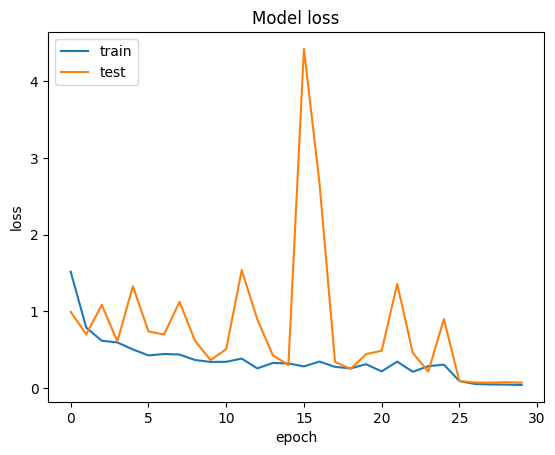

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import cv2


In [53]:
def grad_cam(model, img_path, layer_name):
    img = image.load_img(img_path, target_size=(112, 112))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    grad_model = Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)[0]
    
    # Ensure that grads has at least 3 dimensions
    if len(grads.shape) == 1:
        grads = tf.expand_dims(tf.expand_dims(grads, axis=0), axis=-1)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output_value = conv_output[0].numpy()
    
    # Weighted sum
    weighted_sum = np.sum(conv_output_value * pooled_grads.numpy(), axis=-1)
    
    # Normalize
    heatmap = np.maximum(weighted_sum, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img


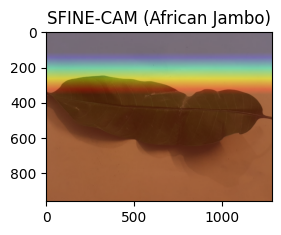

In [60]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/African Jambo/AJo (10).JPG'  # Replace with the actual path to your image

# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (African Jambo)')

plt.show()


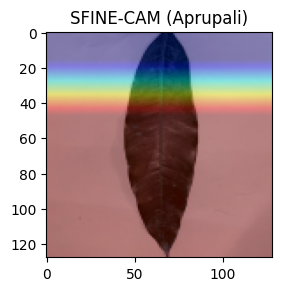

In [62]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Aprupali/Amrupali (166) random_brightness_contrast.png'  # Replace with the actual path to your image

# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Aprupali)')

plt.show()


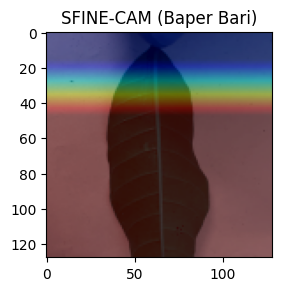

In [64]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Baper Bari/Bbari (1000) random_brightness_contrast.png'  # Replace with the actual path to your image

# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Baper Bari)')

plt.show()


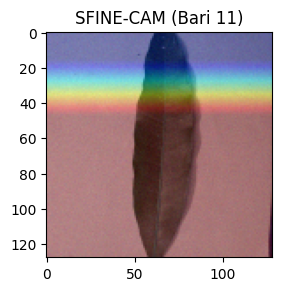

In [68]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Bari 11/bari 11 (175) random_gaussian_noise.png'  # Replace with the actual path to your image

# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Bari 11)')

plt.show()


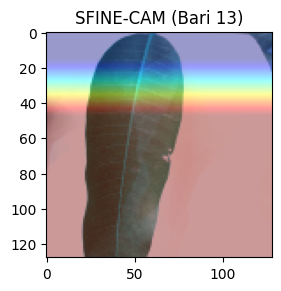

In [72]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Bari 13/Bari 13 (12) random_brightness_contrast.png'  # Replace with the actual path to your image

# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Bari 13)')

plt.show()


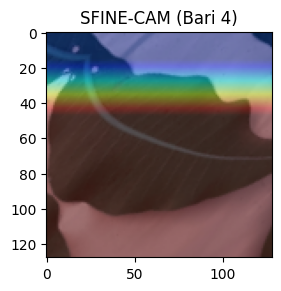

In [77]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Bari 4/bari 4 (100) rotation.png'  # Replace with the actual path to your image

# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Bari 4)')

plt.show()


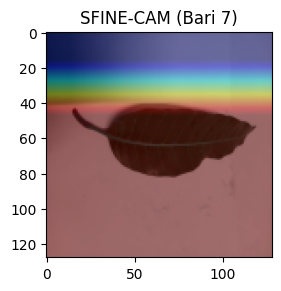

In [82]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Bari 8/Bari 08 (190) random_brightness_contrast.png'  # Replace with the actual path to your image

# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Bari 7)')

plt.show()


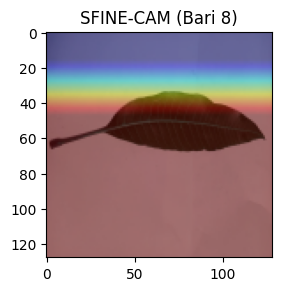

In [92]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Bari 8/Bari 08 (184) random_brightness_contrast.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Bari 8)')

plt.show()


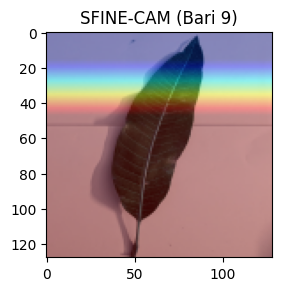

In [100]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Bari 9/Bari 9 (115) random_gaussian_noise.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Bari 9)')

plt.show()


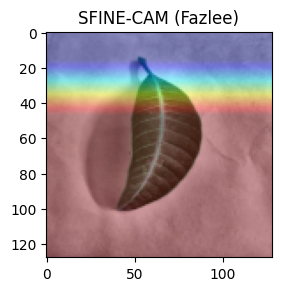

In [102]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Fazlee/fazlee (100) enhance.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Fazlee)')

plt.show()


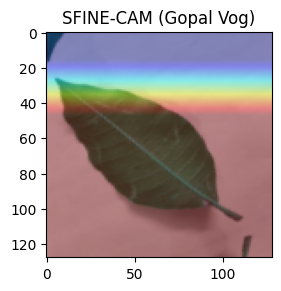

In [107]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Gopal Vog/GopalVog (100) rotation.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Gopal Vog)')

plt.show()


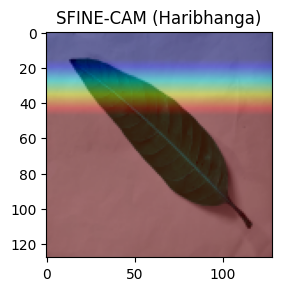

In [112]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Haribhanga/HAB (124) random_brightness_contrast.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Haribhanga)')

plt.show()


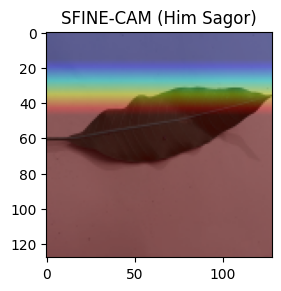

In [118]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Him Sagor/hsagor (203) random_brightness_contrast.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Him Sagor)')

plt.show()


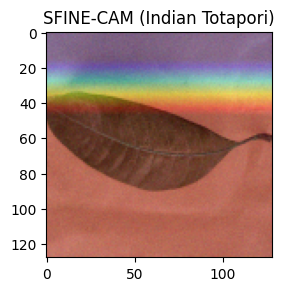

In [122]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Indian Totapori/Indian Totapori (10) random_gaussian_noise.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Indian Totapori)')

plt.show()


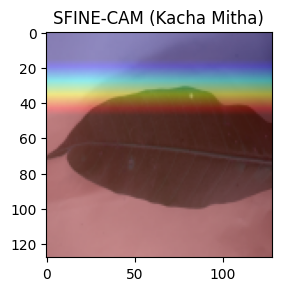

In [130]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Kacha Mitha/kacha mitha (100) flip.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Kacha Mitha)')

plt.show()


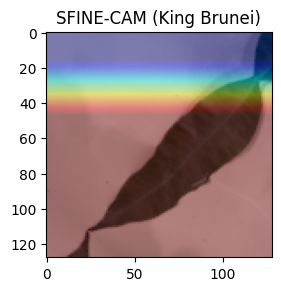

In [150]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/King Breunei/King Brunei (104) rotation.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (King Brunei)')

plt.show()


/tmp/ipykernel_42/1706767669.py:31: RuntimeWarning: invalid value encountered in scalar divide
  heatmap /= np.max(heatmap)
/tmp/ipykernel_42/1706767669.py:35: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


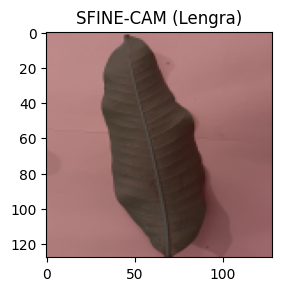

In [238]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Lengra/Lengra (11) random_gaussian_noise.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Lengra)')

plt.show()


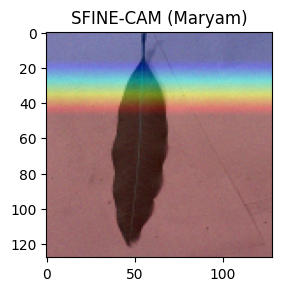

In [191]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Maryam/moriyam (152) random_gaussian_noise.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Maryam)')

plt.show()


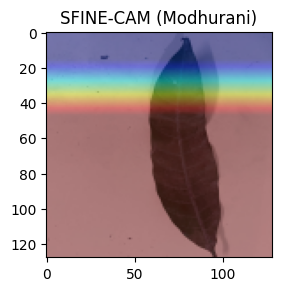

In [193]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Modhurani/Modhurani (1) random_gaussian_noise.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Modhurani)')

plt.show()


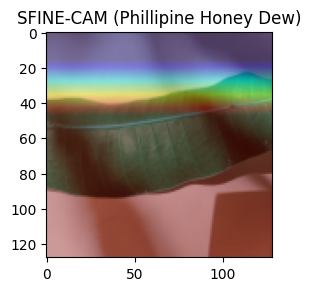

In [199]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Phillipine Honey Dew/PHD (20) flip.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Phillipine Honey Dew)')

plt.show()


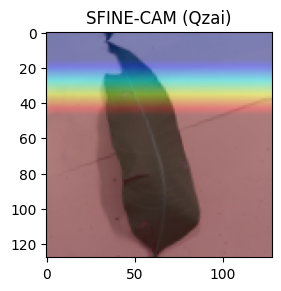

In [207]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Qzai/Qzai  (146) rotation.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Qzai)')

plt.show()


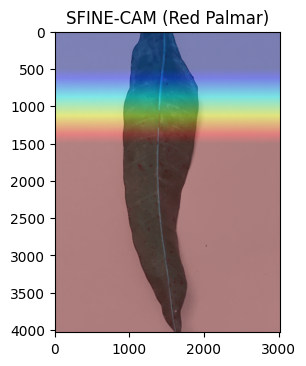

In [209]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Red Palmar/Red palmar (1).jpg'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Red Palmar)')

plt.show()


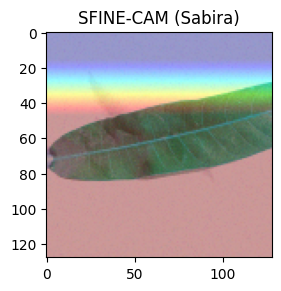

In [218]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Sabira/sabira (110) random_gaussian_noise.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Sabira)')

plt.show()


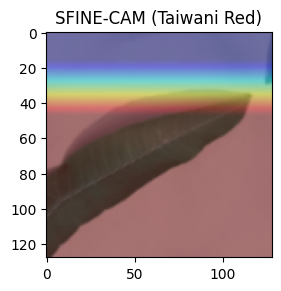

In [220]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Taiwani Red/taiwani Red (11) rotation.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Taiwani Red)')

plt.show()


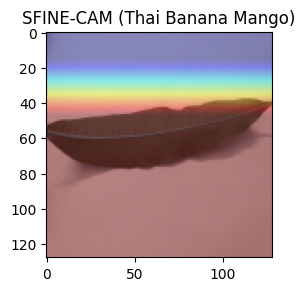

In [223]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Thai Banana Mango/tbm (103) random_brightness_contrast.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Thai Banana Mango)')

plt.show()


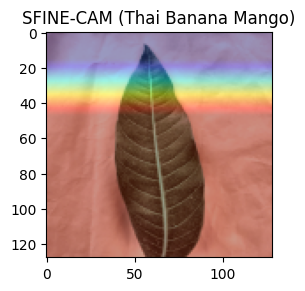

In [224]:
# Choose an image from the test set
img_path = '/kaggle/input/mango-leaf/mango-prepo/train/Thai Moryam/Thai Morium (100) enhance.png'
# Choose the layer for which you want to visualize the attention
# You can find the layer names in your model's summary
layer_name = 'average_1'

# Generate Grad-CAM visualization
cam_image = grad_cam(final_model, img_path, layer_name)

# # Display the original image and Grad-CAM side by side
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.imread(img_path))
# plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('SFINE-CAM (Thai Banana Mango)')

plt.show()


In [51]:
# Choose the layers for which you want to visualize the attention
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3']  # Replace with the actual layer names from your model

# Generate Grad-CAM visualization for multiple layers
cam_image = grad_cam(final_model, img_path, layer_names)

# Display the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(img_path))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('Grad-CAM Visualization')

plt.show()


ValueError: No such layer: conv2d_1. Existing layers are: ['input_4', 'model', 'model_1', 'average_1', 'output_1'].